# <span style="color:teal"> RSNA Screening Mammography Breast Cancer Detection<a class="anchor"  id="projectTopic"></a></span>
### <span style="color:teal"> Detect breast cancers in screening mammograms <a class="anchor"  id="detect"></a></span>

### <span style="color:teal">Developed by : <a class="anchor"  id="detect"></a></span>

* [Gebreyowhans Hailekiros](https://www.kaggle.com/gebreyowhansbahre/)
<!-- * [Mahbub Hasan](https://www.kaggle.com/mahbubulhasan/) -->
* [Muhammad Danish Sadiq](https://www.kaggle.com/muhammaddanishsadiq/)

* This notebook is aimed at developing a neural network model whichi is capable of detecting breast cacers from mamography images.

### <span style="color:teal"> Notebooks <a class="anchor"  id="notebooks"></a></span>
* Image preprocessing Notebook: [RSNA_BCD_DICOM_PNG_ROI](https://www.kaggle.com/code/gebreyowhansh/rsna-bcd-dicom-png-roi)

* Training Notebook: [RSNA_BCD_Train[TPU_VM]_EfficientNet](https://www.kaggle.com/code/gebreyowhansbahre/rsna-bcd-train-tpu-vm-bc86d1)

* Test Notebook: [RSNA-BCD-GPU-TEST_EfficientNet](https://www.kaggle.com/code/gebreyowhansbahre/rsna-bcd-gpu-test/edit/run/128324368)

## <span style="color:teal">1.Install libraries <a class="anchor"  id="libraries"></a></span>

In [1]:
from IPython.display import clear_output
!pip install -qU --upgrade pip
!pip install -qU scikit-learn
clear_output()

In [2]:
!pip install -q /lib/wheels/tensorflow-2.9.1-cp38-cp38-linux_x86_64.whl
!pip install -q tensorflow-addons==0.18.0
!pip install -q tensorflow-probability==0.17.0

!pip install -q opencv-python-headless
!pip install -q seaborn
!pip install -q plotly

!pip install -qU pydot
!pip install -qU graphviz

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.11.0 requires tensorflow<2.12,>=2.11.0; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.9.1 which is incompatible.


In [3]:
#Basic python libraries
%config Completer.use_jedi = False
import os, re, math, random, shutil, warnings, gc
import glob
import numpy as np, pandas as pd
from IPython import display as ipd
from tqdm import tqdm

#Classical Ml tools
import sklearn
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

#OpenCV Library
import cv2

#Plotting tools 
from matplotlib.ticker import StrMethodFormatter
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as py
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

#Tensorflow and keras tools
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,BatchNormalization,Flatten,Input
from keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.applications import EfficientNetB3
from keras.callbacks import EarlyStopping

from kaggle_datasets import KaggleDatasets
from kaggle_secrets import UserSecretsClient

#Logging tools
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # to avoid too many logging messages
pd.options.mode.chained_assignment = None
tf.get_logger().setLevel('ERROR')
py.init_notebook_mode(connected=True)

[percpu.cc : 560] RAW: rseq syscall failed with errno 1
[percpu.cc : 552] RAW: rseq syscall failed with errno 1


In [4]:
print('np:', np.__version__)
print('pd:', pd.__version__)
print('sklearn:', sklearn.__version__)
print('tf:',tf.__version__)

np: 1.24.1
pd: 1.5.3
sklearn: 1.2.2
tf: 2.9.1


## <span style="color:teal">2. Setting basic configurations <a class="anchor"  id="configurations"></a></span>

In [5]:
devices = ['TPU', 'GPU']
class Config:
    
    def __init__(self):
        
        self.debug =False
        self.device=devices[0]
        self.seed=150
        
        #self.path='/kaggle/input/rsna-bcd-converted-dicom-images/'
        self.path='/kaggle/input/bhbahre/'
        
        self.train_path= self.path+'train_images'
        self.train_path = self.path + 'train_images/'
        self.train_csv = self.path + 'train.csv'
        self.train_preprocessed_csv = self.path + 'train_df_processed.csv'
        
        self.weights = "/kaggle/input/efficientnetb3-notop/efficientnetb3_notop.h5"
        
        self.output_path='/kaggle/working/'
        #number of folds for data-split
        self.folds = 5
        # which folds to train
        self.train_folds = [0, 1, 2]
        
        self.oversampling = True
        self.oversampling_factor = 15
        self.threshold = 0.6
        
        #Model Parameters
        self.beta=1.5
        self.batch_size=32
        self.epochs=15
        self.dropout=0.5
        self.optimizer='adam'
        self.loss='binary_crossentropy'
        self.patience=5
        self.img_size =(512,256)
        self.img_ext = 'png'
        
        # ======Augumentation parameters====
        # pixel-augment
        self.sat  = [0.7, 1.3]
        self.cont = [1,2]
        self.bri  = 0.15
        self.hue  = 0.05

config=Config()

## <span style="color:teal">3. Reproducibility <a class="anchor"  id="configurations"></a></span>

In [6]:
def seeding(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    
    print("Seeding done")
    
seeding(config.seed)

Seeding done


## <span style="color:teal">4. Device Configuration <a class="anchor"  id="deviceconfigurations"></a></span>

In [7]:
if config.device == 'TPU':
    
    tpu = 'local' if config.device=='TPU' else None
    print('Connecting to TPU...')
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu=tpu)
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please try executing it again or turnon your TPU VM v3-8 in your accelrator section of this note book !')
    
    policy =tf.keras.mixed_precision.Policy('float32') 
    tf.keras.mixed_precision.set_global_policy(policy)
    
    tf.config.set_soft_device_placement(True)
    #strategy = tf.distribute.experimental.TPUStrategy(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    
    # TPU has to access the dataset from Google Cloud storage(GCS), so we have to set our path to GCS path
#     config.path = KaggleDatasets().get_gcs_path(config.path.split('/')[3])
#     config.train_path = config.path + '/' + 'train_images/'
    
    # get number of TPU cores connect at a runtime
    config.num_devices = strategy.num_replicas_in_sync
    
    # batch size of for the TPU
    config.batch_size = config.batch_size * config.num_devices
    print("Batch size for TPU :",config.batch_size)
    print(f'Running on {config.num_devices} TPU devices')


if config.device == 'GPU':
    
    #Number of GPU core connected
    num_devices = len(tf.config.list_physical_devices('GPU'))
    if num_devices > 1:
        config.num_devices = num_devices
        strategy = tf.distribute.MirroredStrategy()
        config.batch_size = config.batch_size * config.num_devices
        print(f'Running on {num_devices} GPU devices')
        print("Batch size for multi core GPU :",config.batch_size )
        
    elif num_devices == 1:
        strategy = tf.distribute.get_strategy()
        print(f'Running on {num_devices} GPU device')
        
    else:
        strategy = tf.distribute.get_strategy()
        config.device = 'CPU'
        print(f'Running on CPU')
    
    tf.config.optimizer.set_jit(True)
    
    if config.device == 'TPU':
        tf.keras.mixed_precision.set_global_policy("mixed_float16")
    else:
        tf.keras.mixed_precision.set_global_policy(policy="float32")

Connecting to TPU...
Batch size for TPU : 256
Running on 8 TPU devices


## <span style="color:teal">5. Load training data set<a class="anchor"  id="traindataset"></a></span>

In [8]:
train_df = pd.read_csv(config.train_preprocessed_csv)

if config.debug:
    train_df = train_df.sample(1000).reset_index(drop=True)

In [9]:
train_df.head(3)

,site_id,patient_id,image_id,age,cancer,biopsy,invasive,implant,machine_id,age_bin,...,view_MLO,density_A,density_B,density_C,density_D,density_E,difficult_negative_case_False,difficult_negative_case_True,dicom_path,image_path
0,2,10006,462822612,61,0.0,0,0,0,29,2,...,0,0,0,0,0,1,1,0,/kaggle/input/rsna-breast-cancer-detection/tra...,/kaggle/working/train_images/10006/462822612.png
1,2,10006,1459541791,61,0.0,0,0,0,29,2,...,1,0,0,0,0,1,1,0,/kaggle/input/rsna-breast-cancer-detection/tra...,/kaggle/working/train_images/10006/1459541791.png
2,2,10006,1864590858,61,0.0,0,0,0,29,2,...,1,0,0,0,0,1,1,0,/kaggle/input/rsna-breast-cancer-detection/tra...,/kaggle/working/train_images/10006/1864590858.png


In [10]:
train_df = train_df.drop(['dicom_path'], axis=1)

In [11]:
train_df['image_path'] = config.train_path + train_df['patient_id'].astype(str) + '/' + train_df['image_id'].astype(str) + '.png'
train_df['image_path']=train_df['image_path'].astype('string')

In [12]:
tf.io.gfile.exists(train_df.image_path.iloc[0])

True

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   site_id                        54706 non-null  int64  
 1   patient_id                     54706 non-null  int64  
 2   image_id                       54706 non-null  int64  
 3   age                            54706 non-null  int64  
 4   cancer                         54706 non-null  float64
 5   biopsy                         54706 non-null  int64  
 6   invasive                       54706 non-null  int64  
 7   implant                        54706 non-null  int64  
 8   machine_id                     54706 non-null  int64  
 9   age_bin                        54706 non-null  int64  
 10  laterality_L                   54706 non-null  int64  
 11  laterality_R                   54706 non-null  int64  
 12  view_AT                        54706 non-null 

## <span style="color:teal">6. Stratified K-Fold Cross Validation <a class="anchor"  id="stratified"></a></span>

* Stratified k-fold cross-validation is the same as just k-fold cross-validation, but Stratified k-fold  cross-validation, it does stratified sampling instead of random sampling. 

* This is particularly useful when dealing with imbalanced datasets, where one class or outcome variable is much more prevalent than the others.
* Without stratification, a standard K-Fold Cross Validation could lead to some folds containing little or no instances of the minority class, which would bias the evaluation of the model's performance.
* So since our dataset is highly imbalanced we decided to use this kind of cros validation in this project because it ensures that the sample is representative of the population with respect to the actuall population.

In [14]:
stratified_columns = train_df.columns[~train_df.columns.isin(['patient_id', 'image_id', 
                                                              'image_path', 'site_id', 
                                                              'age', 'invasive', 'implant', 
                                                              'machine_id'])]

train_df['stratify'] = ''
for col in stratified_columns:
    train_df['stratify'] += train_df[col].astype(str)
     

train_df['stratify'] = train_df['stratify'].astype('string')



k_fold = StratifiedGroupKFold(n_splits=config.folds, shuffle=True, random_state=config.seed)
for fold, (train_idx, val_idx) in enumerate(k_fold.split(train_df, 
                                                         train_df['stratify'],    #to ensure percentage of  sampling accross all folds is preserved
                                                         train_df['patient_id'])):# to make sure a patient occuress in only one fold in the test set
    train_df.loc[val_idx, 'fold'] = fold
    
    

train_df['fold'] = train_df['fold'].astype('int32')

/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:909: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54706 entries, 0 to 54705
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   site_id                        54706 non-null  int64  
 1   patient_id                     54706 non-null  int64  
 2   image_id                       54706 non-null  int64  
 3   age                            54706 non-null  int64  
 4   cancer                         54706 non-null  float64
 5   biopsy                         54706 non-null  int64  
 6   invasive                       54706 non-null  int64  
 7   implant                        54706 non-null  int64  
 8   machine_id                     54706 non-null  int64  
 9   age_bin                        54706 non-null  int64  
 10  laterality_L                   54706 non-null  int64  
 11  laterality_R                   54706 non-null  int64  
 12  view_AT                        54706 non-null 

In [16]:
print(train_df.groupby(['fold', "cancer"]).size())

fold  cancer
0     0.0       10694
      1.0         236
1     0.0       10631
      1.0         218
2     0.0       10738
      1.0         267
3     0.0       10685
      1.0         203
4     0.0       10800
      1.0         234
dtype: int64


In [17]:
train_df.head(3)

,site_id,patient_id,image_id,age,cancer,biopsy,invasive,implant,machine_id,age_bin,...,density_A,density_B,density_C,density_D,density_E,difficult_negative_case_False,difficult_negative_case_True,image_path,stratify,fold
0,2,10006,462822612,61,0.0,0,0,0,29,2,...,0,0,0,0,1,1,0,/kaggle/input/bhbahre/train_images/10006/46282...,0.002100100000000110,0
1,2,10006,1459541791,61,0.0,0,0,0,29,2,...,0,0,0,0,1,1,0,/kaggle/input/bhbahre/train_images/10006/14595...,0.002100000010000110,0
2,2,10006,1864590858,61,0.0,0,0,0,29,2,...,0,0,0,0,1,1,0,/kaggle/input/bhbahre/train_images/10006/18645...,0.002010000010000110,0


#### <span style="color:teal">6.1. Counts of Samples by Fold and Cancer <a class="anchor"  id="sample_plot"></a></span>

In [18]:
counts_df = train_df.groupby(['fold', 'cancer'])['cancer'].count().reset_index(name='count')

fig = px.bar(counts_df, x='fold', y='count', color='cancer', barmode='stack',
             hover_data={'fold': True, 'cancer': True, 'count': True},
             labels={'fold': 'Fold', 'count': 'Count', 'cancer': 'Cancer',
             })
fig.update_layout(title='Counts of Samples by Fold and Cancer', xaxis_tickangle=-45)
fig.show()

## <span style="color:teal">7. Data Pipeline <a class="anchor"  id="pipline"></a></span>

#### <span style="color:teal">7.1 Decode images <a class="anchor"  id="decode"></a></span>
 * **tf.image.decode_png()** and **tf.image.decode_jpeg** are TensorFlow functions that decodes a PNG-encoded   image into a tensor of type uint8.
 
 * These functions takes the following arguments: 
     * **image**: A string tensor containing a PNG or jpeg -encoded image.
     * **channels**: An optional integer specifying the number of color channels in the decoded image. By  default, this is set to 3,
     

* The function returns a **uint8** tensor representing the decoded image with the shape of (height, width, channels) 
 


In [19]:
def decode_image(label=True, img_size=config.img_size, ext=config.img_ext):
    
    def _decode_image(Input_Image, label=None):
        image = tf.io.read_file(Input_Image['input_image'])
        
        if ext == 'png':
            ## PNG-encoded image into a tensor of type uint8.
            image = tf.image.decode_png(image, channels=3)
        elif ext in ['jpg', 'jpeg']:
            ## jpeg-encoded image into a tensor of type uint8.
            image = tf.image.decode_jpeg(image, channels=3)
        else:
            raise ValueError("Image extension not supported")
        
        ## explicit size needed for TPU
        image = tf.image.resize(image, img_size)
        ## convert image to floats in [0, 1] range
        image = tf.cast(image, tf.float32) / 255.0
        
        Input_Image['input_image'] = image
        
        if label is None:
            return Input_Image
        else:
            return Input_Image, label
    
    if label:
        return _decode_image
    else:
        return lambda x: _decode_image(x, None)

#### <span style="color:teal">7.2 Data augumentation<a class="anchor"  id="augumentation"></a></span>
* Using Augmentations to reduce overfitting and make model more robust by :
 * 1. random_flip_left_right for applying position transforamtion
 * 2. perofrming some random_hue,random_saturation,random_contrast,random_brightness for pixel transforamtion

In [20]:
def data_augment(label=True):
    def _augment(Input_Image, label=None):
        image = Input_Image['input_image']
        #position transforamtion
        image = tf.image.random_flip_left_right(image)
        # pixel-augment
        image = tf.image.random_hue(image, config.hue)
        image = tf.image.random_saturation(image,config.sat[0], config.sat[1])
        image = tf.image.random_contrast(image,config.cont[0], config.cont[1])
        image = tf.image.random_brightness(image,config.bri)
        Input_Image['input_image'] = image
        if label is not None:
            return Input_Image, label
        else:
            return Input_Image

    if label:
        return _augment
    else:
        return lambda x: _augment(x, None)


#### <span style="color:teal">7.3 Build tf.data.dataset<a class="anchor"  id="dataset"></a></span>

In [21]:
def build_dataset(df, input_features, image_size=config.img_size, batch_size=config.batch_size, 
                  label=True, shuffle=True, augment=False, repeat=False, cache=False, ext=config.img_ext):
    
    decode = decode_image(label, img_size=image_size, ext=ext)
    input_data = {'input_image': df['image_path'].values, 
                  'input_features': df[input_features].values}
    
    if label:
        label_data = df['cancer'].apply(lambda x: int(x)).values
        dataset = tf.data.Dataset.from_tensor_slices((input_data, label_data))
        
    else:
        dataset = tf.data.Dataset.from_tensor_slices(input_data)
        
    dataset = dataset.map(decode, num_parallel_calls=tf.data.AUTOTUNE)
    
    
    
    if augment:
        dataset = dataset.map(data_augment(label), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(batch_size, reshuffle_each_iteration=True)
    if repeat:
        dataset = dataset.repeat()
    if cache:
        dataset = dataset.cache()
        
    dataset = dataset.batch(batch_size, drop_remainder=shuffle)
    
#     for _dt in dataset.take(10):
#             print(_dt)
            
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


## <span style="color:teal">8. Defining input features <a class="anchor"  id="input-features"></a></span>

* These inpute features are medical characteristics of the patient that the model has to consider during training in addition the image.

In [22]:
input_features = train_df.columns.difference(['patient_id', 'image_id', 'site_id',
                                              'machine_id','cancer','age', 
                                              'stratify', 'image_path', 'fold'])
input_features

Index(['age_bin', 'biopsy', 'density_A', 'density_B', 'density_C', 'density_D',
       'density_E', 'difficult_negative_case_False',
       'difficult_negative_case_True', 'implant', 'invasive', 'laterality_L',
       'laterality_R', 'view_AT', 'view_CC', 'view_LM', 'view_LMO', 'view_ML',
       'view_MLO'],
      dtype='object')


#### <span style="color:teal">8.1 Normalizating input features <a class="anchor"  id="normalization"></a></span>

In [23]:
train_df[input_features] = (train_df[input_features] - train_df[input_features].mean()) / train_df[input_features].std()
train_df[input_features] = train_df[input_features].fillna(0).astype('float32')
train_df[input_features].head(3)

,age_bin,biopsy,density_A,density_B,density_C,density_D,density_E,difficult_negative_case_False,difficult_negative_case_True,implant,invasive,laterality_L,laterality_R,view_AT,view_CC,view_LM,view_LMO,view_ML,view_MLO
0,-0.114632,-0.239552,-0.2453,-0.548466,-0.535029,-0.170135,1.080627,0.404882,-0.404882,-0.166576,-0.123205,1.003140,-1.003140,-0.018639,1.021724,-0.013521,-0.004275,-0.012094,-1.020304
1,-0.114632,-0.239552,-0.2453,-0.548466,-0.535029,-0.170135,1.080627,0.404882,-0.404882,-0.166576,-0.123205,1.003140,-1.003140,-0.018639,-0.978720,-0.013521,-0.004275,-0.012094,0.980082
2,-0.114632,-0.239552,-0.2453,-0.548466,-0.535029,-0.170135,1.080627,0.404882,-0.404882,-0.166576,-0.123205,-0.996852,0.996852,-0.018639,-0.978720,-0.013521,-0.004275,-0.012094,0.980082



#### <span style="color:teal">8.2. Save the prepared training dataset for next use <a class="anchor"  id="savetraincsv"></a></span>

In [24]:
train_df.to_csv("train_df_processed.csv", sep=',',index=False)

## <span style="color:teal">9. Some Visualizations of augumented and non augumented images<a class="anchor"  id="visualizations"></a></span>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


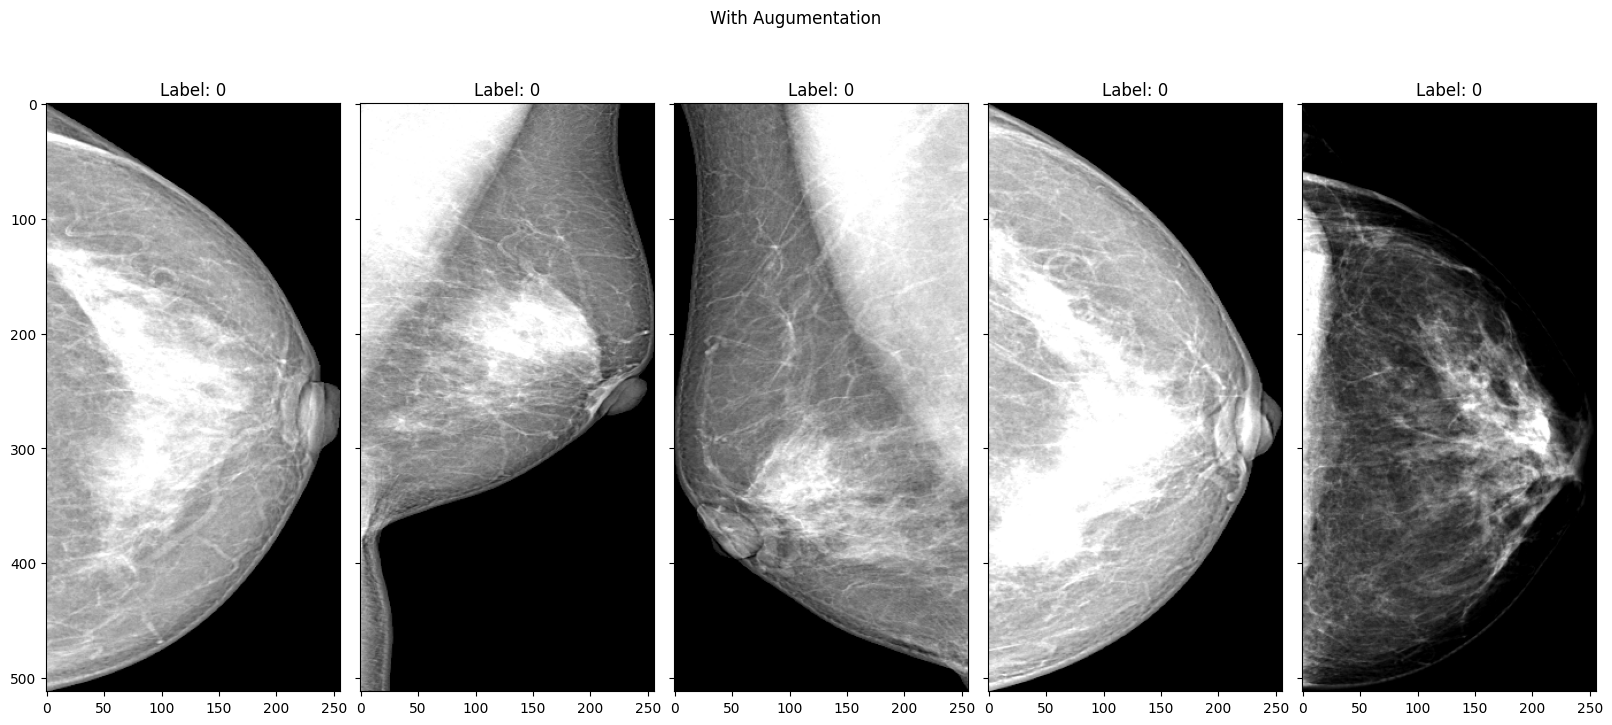

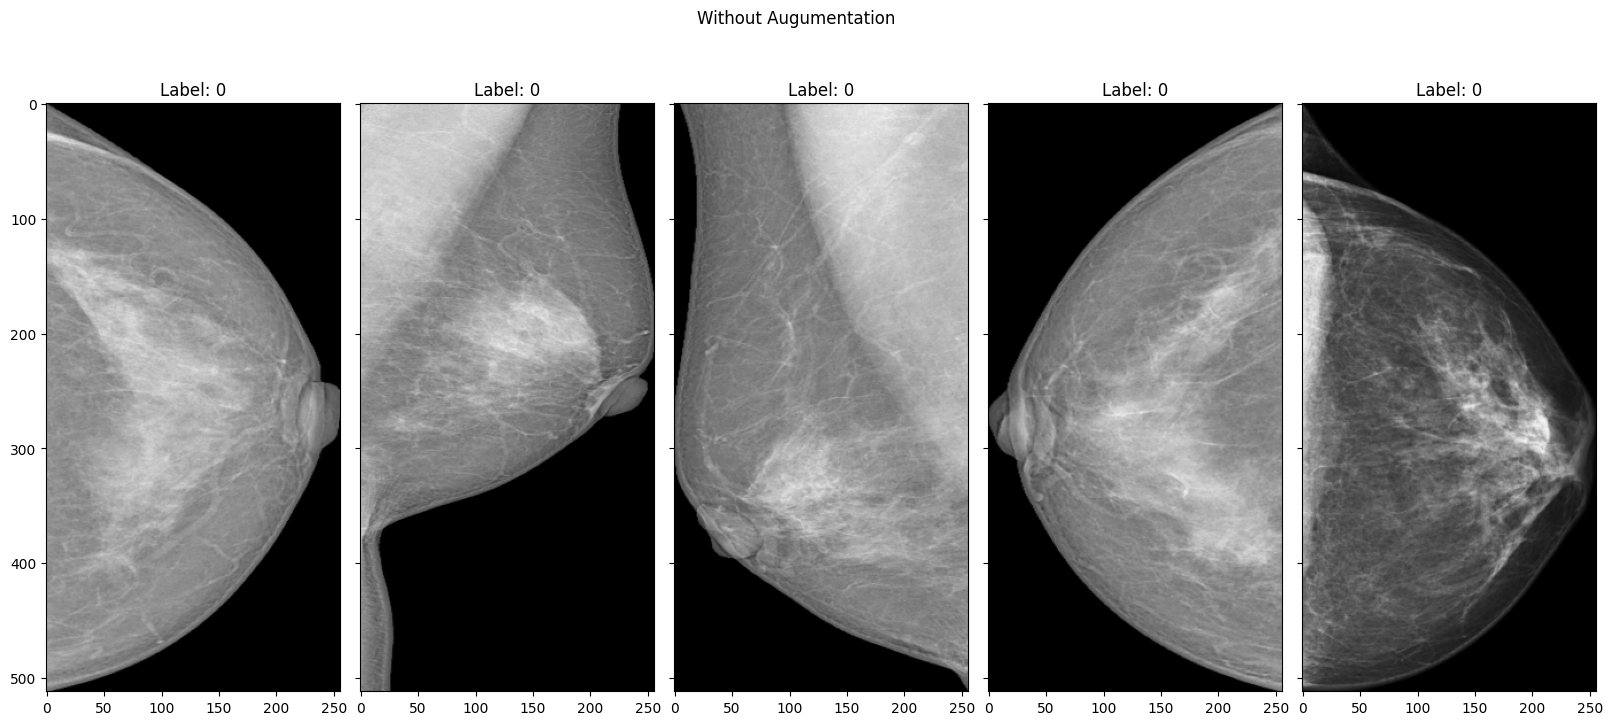

In [25]:
def show_images(dataset,  title="", rows=1, cols=5, figsize=(20, 8)):
    fig = plt.figure(figsize=figsize)
    grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols), axes_pad=0.2)
    for i, (images, labels) in enumerate(dataset.take(1)):
        for j in range(rows*cols):
            grid[j].imshow(images['input_image'][j].numpy())
            grid[j].set_title(f"Label: {labels[j].numpy()}")
    plt.suptitle(title)
    plt.show()

augumented = build_dataset(train_df, input_features, batch_size=config.batch_size, label=True, 
                                     shuffle=False, augment=True, repeat=False, cache=False, ext=config.img_ext)

non_augument = build_dataset(train_df, input_features, batch_size=config.batch_size, label=True, 
                                        shuffle=False, augment=False, repeat=False, cache=False, ext=config.img_ext)


show_images(augumented, title="With Augumentation")
show_images(non_augument, title="Without Augumentation")

## <span style="color:teal">10. Define evaluation metrics <a class="anchor"  id="evaluationmetrix"></a></span>

In [26]:
def p_f1(y_true, y_pred, beta=config.beta):
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    tn = tf.reduce_sum(tf.cast((1 - y_true) * (1 - y_pred), tf.float32))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, tf.float32))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), tf.float32))

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    beta_square = beta ** 2
    numerator = (1 + beta_square) * p * r
    denominator = beta_square * p + r + tf.keras.backend.epsilon()
    
    f1 = numerator / denominator
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    return tf.reduce_mean(f1)


def p_f1_np(y_true, y_pred, beta=1):
    tp = np.sum(y_true * y_pred)
    tn = np.sum((1 - y_true) * (1 - y_pred))
    fp = np.sum((1 - y_true) * y_pred)
    fn = np.sum(y_true * (1 - y_pred))
    
    p = tp / (tp + fp + np.finfo(np.float32).eps)
    r = tp / (tp + fn + np.finfo(np.float32).eps)
    
    beta_squared = beta ** 2
    
    f1 = ((1 + beta_squared) * p * r) / (beta_squared * p + r + np.finfo(np.float32).eps)
    f1 = np.where(np.isnan(f1), np.zeros_like(f1), f1)
    
    return np.mean(f1).astype(np.float32)

## <span style="color:teal">11. Model Building <a class="anchor"  id="model-building"></a></span>

In [27]:
def build_model(input_features, 
                loss=config.loss, 
                dropout=config.dropout, 
                optimizer=config.optimizer, 
                img_size=config.img_size):
    with strategy.scope():
        input_image = tf.keras.layers.Input(shape=(*img_size,3), 
                                            name='input_image')
        input_features = tf.keras.layers.Input(shape=[len(input_features)],
                                               name='input_features')
        
        efficientNetB3Base_model = tf.keras.applications.EfficientNetB3(input_shape=(*img_size,3),
                                                 include_top=False, 
                                                 drop_connect_rate=0.3,
                                                 weights='imagenet')(input_image)
        #reduce the spatial dimensions of a feature map produced by a pre-trained EfficientNetB3
        x = tf.keras.layers.GlobalAveragePooling2D()(efficientNetB3Base_model)
        
        x = tf.keras.layers.Dense(128,activation="relu")(x)
        _output = tf.keras.layers.Dropout(dropout)(x)
        #normalizes its input by subtracting the batch mean and dividing by the batch standard deviation
        _output = tf.keras.layers.BatchNormalization()(_output)
        _output = tf.keras.layers.Dense(64,activation="relu")(_output)
        _output = tf.keras.layers.Dropout(dropout)(_output)
        _output = tf.keras.layers.BatchNormalization()(_output)
        _output = tf.keras.layers.Dense(32,activation="relu")(_output)
        _output = tf.keras.layers.BatchNormalization()(_output)
        _output = tf.keras.layers.Dense(16,activation="relu")(_output)
        _output = tf.keras.layers.BatchNormalization()(_output)  
        _output = tf.keras.layers.Concatenate()([_output, input_features])
        _output = tf.keras.layers.Dense(1, activation='sigmoid')(_output)
        
        model = tf.keras.Model(inputs=[input_image, input_features], outputs=_output)
        
        model.compile(optimizer=optimizer,
                      loss=loss,
                      metrics=['accuracy', 
                               p_f1])

        return model


#### <span style="color:teal">11.2 Model summary <a class="anchor"  id="model-summary"></a></span>

In [28]:
model = build_model(input_features,config.loss,config.dropout,config.optimizer,config.img_size)
model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 512, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 efficientnetb3 (Functional)    (None, 16, 8, 1536)  10783535    ['input_image[0][0]']            
                                                                                                  
 global_average_pooling2d (Glob  (None, 1536)        0           ['efficientnetb3[0][0]']         
 alAveragePooling2D)                                                                              
                             

#### <span style="color:teal">11.3 Ploting the model<a class="anchor"  id="plot-model"></a></span>

In [29]:
tf.keras.utils.plot_model(model, to_file='model.png',show_shapes=True, dpi=64)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## <span style="color:teal">12. Defining custom callbacks<a class="anchor"  id="compilation"></a></span>

#### <span style="color:teal">12.1 Custom Learning rate scheduler<a class="anchor"  id="lr-schedul"></a></span>
* In this project we used to implement a custom learning rate scheduler based Super-convergence technique as presented in the [Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates](https://arxiv.org/abs/1708.07120) which is a technique that involves training a model with a very high learning rate for a few epochs, followed by decreasing the learning rate to a very low value. This technique can speed up training and help the model converge faster compared to other proposed learning rate schedulers like cyclical learning rates as in [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186) or defualt learning rates that comes with the optimzier functions.




In [30]:
class LRScheduler(tf.keras.callbacks.Callback):
    def __init__(self,base_lr=1e-5, max_lr=1e-2, mode='triangular', step_size=10):
        super(LRScheduler, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.mode = mode
        self.step_size = step_size
        self.history = {}

    def on_train_begin(self, logs={}):
        self.iterations = 0
        self.history['lr'] = []

    def on_batch_end(self, batch, logs={}):
        self.iterations += 1
        cycle = np.floor(1 + self.iterations / (2 * self.step_size))
        x = np.abs(self.iterations / self.step_size - 2 * cycle + 1)
        
        if self.mode == 'triangular':
            self.lr = self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x))
            
        elif self.mode == 'super_convergence':
            self.lr = self.base_lr + (self.max_lr - self.base_lr) * np.minimum(x, 1 - x)
            
        self.history['lr'].append(self.lr)
    
    def plot_lr(self):
        plt.plot(self.history['lr'])
        plt.title('Learning rate schedule')
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.show()   

#### <span style="color:teal">12.2 Defining modelCheckpoint and earlyStopping callbacks <a class="anchor"  id="early-stopping"></a></span>

In [31]:
# Create directory model weightes saving
save_model_dir = os.path.join(config.output_path,'models')
os.makedirs(os.path.dirname(save_model_dir), exist_ok=True)

def get_callbacks(batch_size, fold, patience=config.patience):
    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                             mode="min",
                                             patience=patience,
                                             restore_best_weights=True)
    
    best_model = tf.keras.callbacks.ModelCheckpoint(f'{save_model_dir}/model_{fold}.h5', 
                                                    monitor='val_p_f1',
                                                    mode='max', 
                                                    save_freq='epoch', 
                                                    save_best_only=True, 
                                                    save_weights_only=False,
                                                    verbose=1)
    callbacks_list = [early_stop, 
                      best_model,
                      lr_scheduler,
                     ]
    return callbacks_list

## <span style="color:teal">13. Model training and evaluation <a class="anchor"  id="train_evaluate"></a></span>
#### <span style="color:teal">13.1 Model training <a class="anchor"  id="training"></a></span>

In [32]:
    
results = {}
for val_fold in range(config.folds):
    
    if val_fold in config.train_folds:
        continue
    
    print(f'\n- Fold [{val_fold}] as validation set, and folds {[i for i in range(config.folds) if i != val_fold]} as training set\n')
    
    train = train_df.query("fold != @val_fold")
    validation = train_df.query("fold == @val_fold")
    
    print("number of examples in training : ",len(train))
    print("number of examples in validation : ",len(validation))

    if config.oversampling:
        number_of_cancers=train.query('cancer == 1')
        number_of_noncancer=train.query('cancer == 0')
        
        print("number of cancers :",len(number_of_cancers))
        print("number of non cancer :",len(number_of_noncancer))
        positive = train.query('cancer == 1').sample(frac=config.oversampling_factor, replace=True, 
                                                     random_state=config.seed)
        
        negative = train.query('cancer == 0')
        train = pd.concat([positive, negative], axis=0).reset_index(drop=True)
        
        print("number of examples in after overs sampling : ",len(train))
    
    train_dataset = build_dataset(train, input_features, batch_size=config.batch_size, 
                                  shuffle=True, augment=True, repeat=False, cache=True)
          
    val_dataset = build_dataset(validation, input_features, batch_size=config.batch_size, 
                                shuffle=False, augment=False, repeat=False, cache=True)
    
    class_weight = compute_class_weight(class_weight='balanced',
                                        classes=train["cancer"].unique(),
                                        y=train["cancer"].values)
    
    model = build_model(input_features)
    
    steps_per_epoch = len(train) // config.batch_size
    
    # create the lr_scheduler object
    lr_scheduler = LRScheduler(base_lr=1e-5, 
                               max_lr=1e-1,
                               mode='super_convergence', 
                               step_size=steps_per_epoch)
    
    history = model.fit(train_dataset, 
                        validation_data = val_dataset, 
                        epochs = config.epochs,
                        callbacks = get_callbacks(config.batch_size, val_fold),
                        class_weight = dict(zip(train["cancer"].unique(), class_weight)),
                        steps_per_epoch =steps_per_epoch)
    
    
    print('========================performing out-of-fold predictions ============================================')
    print('======== Loading saved model ========================')
    model.load_weights(f'{save_model_dir}/model_{val_fold}.h5')

    print('================Predicting OOF validation set ========================')
    test_val_dataset= build_dataset(validation, input_features,
                                  batch_size=config.batch_size, 
                                  shuffle=False, augment=True, 
                                  repeat=False, cache=True)
    
    
    #Remove singleton dimensionality with squeeze function
    validation['pred'] = np.squeeze(model.predict(test_val_dataset, verbose=1).astype('float32'))
    validation['pred'] = (validation['pred'] > config.threshold).astype(int)
    
    
    print(' ================Compute metrics========================')
    pf = p_f1(validation['cancer'], validation['pred'],config.beta)
    accuracy = accuracy_score(validation['cancer'], validation['pred'])

    
    results[val_fold] = {'p_f1': pf,'accuracy': accuracy}
    print(f'- P-F1: {pf}, Accuracy: {accuracy}\n')
   
    del model
    gc.collect()
    tf.keras.backend.clear_session()
    


- Fold [3] as validation set, and folds [0, 1, 2, 4] as training set

number of examples in training :  43818
number of examples in validation :  10888
number of cancers : 955
number of non cancer : 42863
number of examples in after overs sampling :  57188
Epoch 1/15


2023-06-20 14:03:41.118395: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2023-06-20 14:03:43.683151: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.


223/223 [==============================] - ETA: 0s - loss: 1.7985 - accuracy: 0.3093 - p_f1: 0.0491

2023-06-20 14:06:08.506058: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-06-20 14:06:09.100351: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.



Epoch 1: val_p_f1 improved from -inf to 0.01092, saving model to /kaggle/working/models/model_3.h5
223/223 [==============================] - 304s 859ms/step - loss: 1.7985 - accuracy: 0.3093 - p_f1: 0.0491 - val_loss: 0.7856 - val_accuracy: 0.4917 - val_p_f1: 0.0109
Epoch 2/15
223/223 [==============================] - ETA: 0s - loss: 1.4111 - accuracy: 0.2812 - p_f1: 0.0712
Epoch 2: val_p_f1 improved from 0.01092 to 0.02136, saving model to /kaggle/working/models/model_3.h5
223/223 [==============================] - 92s 410ms/step - loss: 1.4111 - accuracy: 0.2812 - p_f1: 0.0712 - val_loss: 0.8411 - val_accuracy: 0.4411 - val_p_f1: 0.0214
Epoch 3/15
223/223 [==============================] - ETA: 0s - loss: 1.0075 - accuracy: 0.3187 - p_f1: 0.1168
Epoch 3: val_p_f1 improved from 0.02136 to 0.03624, saving model to /kaggle/working/models/model_3.h5
223/223 [==============================] - 92s 412ms/step - loss: 1.0075 - accuracy: 0.3187 - p_f1: 0.1168 - val_loss: 0.8118 - val_accur

2023-06-20 14:29:54.022874: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-06-20 14:29:54.621853: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


43/43 [==============================] - 115s 1s/step
 ================Compute metrics========================
- P-F1: 0.8154981732368469, Accuracy: 0.9954077883908891


- Fold [4] as validation set, and folds [0, 1, 2, 3] as training set

number of examples in training :  43672
number of examples in validation :  11034
number of cancers : 924
number of non cancer : 42748
number of examples in after overs sampling :  56608
Epoch 1/15


2023-06-20 14:33:02.309756: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2023-06-20 14:33:05.075772: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.


221/221 [==============================] - ETA: 0s - loss: 0.5419 - accuracy: 0.6121 - p_f1: 0.2113

2023-06-20 14:35:27.632876: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-06-20 14:35:28.357939: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.



Epoch 1: val_p_f1 improved from -inf to 0.07845, saving model to /kaggle/working/models/model_4.h5
221/221 [==============================] - 278s 762ms/step - loss: 0.5419 - accuracy: 0.6121 - p_f1: 0.2113 - val_loss: 0.5661 - val_accuracy: 0.7432 - val_p_f1: 0.0785
Epoch 2/15
221/221 [==============================] - ETA: 0s - loss: 0.3935 - accuracy: 0.8083 - p_f1: 0.2193
Epoch 2: val_p_f1 improved from 0.07845 to 0.09220, saving model to /kaggle/working/models/model_4.h5
221/221 [==============================] - 92s 416ms/step - loss: 0.3935 - accuracy: 0.8083 - p_f1: 0.2193 - val_loss: 0.4019 - val_accuracy: 0.9751 - val_p_f1: 0.0922
Epoch 3/15
221/221 [==============================] - ETA: 0s - loss: 0.2950 - accuracy: 0.9330 - p_f1: 0.2226
Epoch 3: val_p_f1 improved from 0.09220 to 0.11351, saving model to /kaggle/working/models/model_4.h5
221/221 [==============================] - 92s 417ms/step - loss: 0.2950 - accuracy: 0.9330 - p_f1: 0.2226 - val_loss: 0.2309 - val_accur

2023-06-20 14:58:53.709510: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-06-20 14:58:54.323161: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


44/44 [==============================] - 90s 913ms/step
 ================Compute metrics========================
- P-F1: 1.0, Accuracy: 1.0



#### <span style="color:teal">13.2 Plot of the LR_Scheduler <a class="anchor"  id="lrScheduler"></a></span>

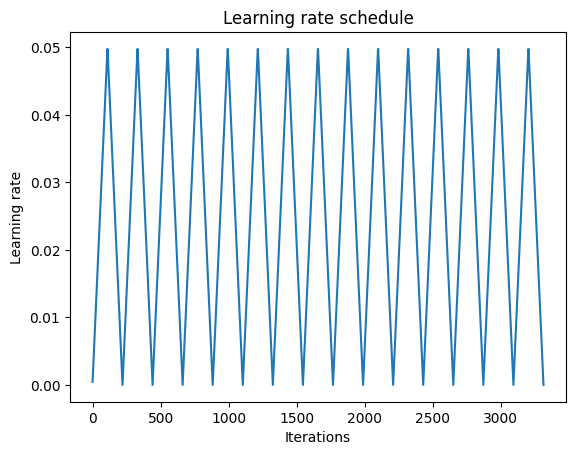

In [33]:
lr_scheduler.plot_lr()

#### <span style="color:teal">13.3 Final evaluation results <a class="anchor"  id="results"></a></span>

In [34]:
print('\n Final results:')
print(f'- P-F1: {np.mean([results[i]["p_f1"] for i in results])}')
print(f'- Accuracy: {np.mean([results[i]["accuracy"] for i in results])}')


 Final results:
- P-F1: 0.9077490568161011
- Accuracy: 0.9977038941954446


#### <span style="color:teal">14.4 Plot of accuracy and loss functions <a class="anchor"  id="plotting"></a></span>



In [35]:
def plot_evaluation_metrics(history):
    #Accuracy
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, "r", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "g", label="Validation accuracy")
    
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training loss")
    plt.plot(epochs, val_loss, "g", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()
    
    # PF1-Score
    pf1 = history.history["p_f1"]
    val_pf1 = history.history["val_p_f1"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, pf1, "r", label="Training Pf1")
    plt.plot(epochs, val_pf1, "g", label="Validation Pf1")
    plt.title("Training and validation pf1")
    plt.legend()
    plt.show()


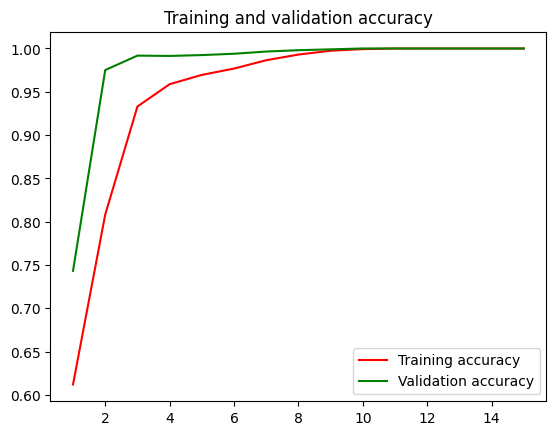

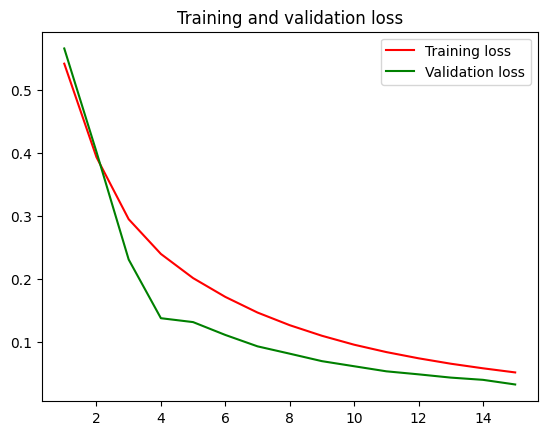

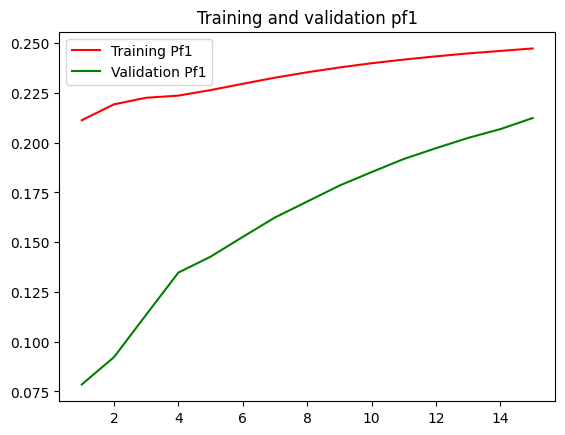

In [36]:
plot_evaluation_metrics(history)

In [37]:
tf.keras.backend.clear_session()
# experiment.end()